# Coherence 
![Screenshot from 2019-11-15 18-08-00](https://user-images.githubusercontent.com/33189954/68930988-e97c8580-07d2-11ea-9f85-ab0927e1e712.png)

![Screenshot from 2019-11-15 18-08-50](https://user-images.githubusercontent.com/33189954/68931021-fe591900-07d2-11ea-9ffc-1e85364e2bfd.png)

In [1]:
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from keras.applications.vgg16 import (
    VGG16, preprocess_input, decode_predictions)
from keras.preprocessing import image
from keras.layers.core import Lambda
from keras.models import Sequential
from tensorflow.python.framework import ops
import keras.backend as K
import tensorflow as tf
import numpy as np
import keras
import sys
import cv2

Using TensorFlow backend.
/home/jake/venv/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/jake/venv/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/jake/venv/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/jake/venv/lib/python3.7/site-packages/tensorboard/

In [3]:
#!pip install tqdm

In [4]:
import keras
import tensorflow as tf
import tqdm

In [7]:
from keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [8]:

label_list = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [9]:
os.environ["CUDA_VISIBLE_DEVICES"]="1";  
from keras.backend.tensorflow_backend import set_session
config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.8
tf.compat.v1.Session(config=config)

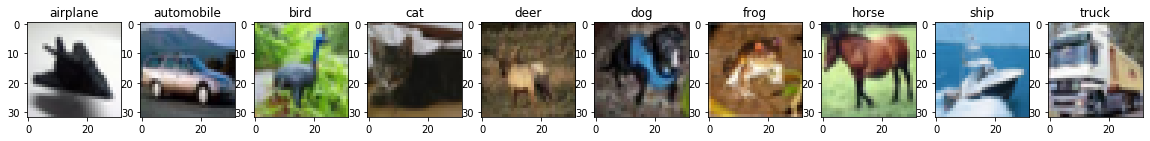

In [11]:
plt.figure(figsize=(20, 20))
for i in range(10):
    plt.subplot(1,10,i+1)
    coord = np.where(y_train.flatten() == i)[0][0]
    plt.imshow(x_train[coord])
    plt.title(label_list[y_train[coord][0]])

plt.show()

In [13]:
model = tf.keras.models.load_model('../models/cifar10_gradcam.h5')

In [14]:
model.compile(loss='categorical_crossentropy', 
          optimizer='adam', 
          metrics=['accuracy'])

In [15]:
def get_smoothgrad(img_input, saliency, n=10, sigma=1):
    result = np.zeros_like(img_input)
    for i in range(n):
        result += saliency([img_input + np.random.normal(scale=sigma, size=img_input.shape)])[0]
    
    return result / n


In [16]:
batch_size = 100
iteration = 100
sigma = 1
isplot = False

tot_score = {i: [] for i in range(10)}

In [13]:
tot_score

{0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: []}

In [17]:
for label in range(10):
    print('***** label {} *****'.format(label))
    y_c = model.output[0, label]
    grads = keras.backend.gradients(y_c, model.input)[0]
    saliency = keras.backend.function([model.input], [grads])
    
    idx_coord = np.where(y_test == label)[0]
    X = np.zeros((batch_size, 32, 32, 3))
    for batch in range(batch_size):
        X[batch] = x_test[idx_coord[batch]]/255
        
    Y = np.array([[1 if label==i else 0 for i in range(10)] for _ in range(batch_size)])
    
    for batch in tqdm.trange(batch_size):
        x_input = X[batch].copy()
        y_input = Y[batch].copy()
        
        score_list = []
        if isplot:
            plt.figure(figsize=(30,30))
            
        for it in range(iteration):
            score = model.evaluate(x_input[np.newaxis,...], y_input[np.newaxis,...], verbose=0)[1]
            score_list.append(score)
            
            gradmap = np.abs(np.squeeze(get_smoothgrad(x_input[np.newaxis,...], saliency, sigma=sigma)))
            
            if isplot:
                plt.subplot(1,20,2*(it%10)+1)
                plt.imshow(np.squeeze(x_input))
                plt.subplot(1,20,2*(it%10)+2)
                plt.imshow(np.squeeze(gradmap))
                if it%10 == 9:
                    plt.show()
                    plt.figure(figsize=(30,30))
            
            coord = np.where(gradmap == gradmap.max())
            x_input[coord] = 0.
        
        tot_score[label].append(score_list)

  0%|          | 0/100 [00:00<?, ?it/s]

***** label 0 *****


  0%|          | 0/100 [00:00<?, ?it/s]

***** label 1 *****


  0%|          | 0/100 [00:00<?, ?it/s]

***** label 2 *****


  0%|          | 0/100 [00:00<?, ?it/s]

***** label 3 *****


  0%|          | 0/100 [00:00<?, ?it/s]

***** label 4 *****


  0%|          | 0/100 [00:00<?, ?it/s]

***** label 5 *****


  0%|          | 0/100 [00:00<?, ?it/s]

***** label 6 *****


  0%|          | 0/100 [00:00<?, ?it/s]

***** label 7 *****


100%|██████████| 100/100 [13:55<00:00,  8.35s/it]


***** label 8 *****


100%|██████████| 100/100 [13:28<00:00,  8.09s/it]


***** label 9 *****


100%|██████████| 100/100 [14:10<00:00,  8.51s/it]


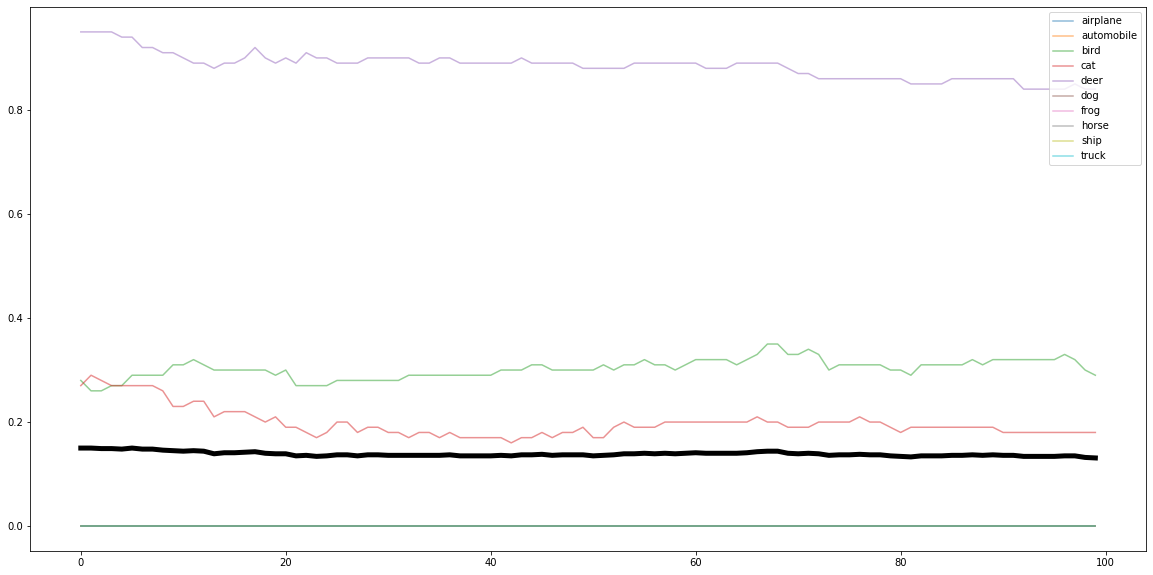

In [18]:
plt.figure(figsize=(20,10))
for i, k in enumerate(tot_score.keys()):
    plt.plot(np.array(tot_score[k]).mean(axis=0), alpha=.5, label=label_list[k])
    
    if i == 0:
        total = np.array(tot_score[k]).mean(axis=0)
    else:
        total += np.array(tot_score[k]).mean(axis=0)
        
total /= 10
plt.plot(total, color='black', linewidth=5)
plt.legend(loc=1)
# plt.xlim((0, 100))
# plt.ylim((0., 1.))
plt.show()